# Clustering of e-commerce customers 

The goal is to test multiple unsupervised ML clustering algorithms and to create customer segmentation of brazilian e-commerce platform Olist Store, based on their transactions. 
The following algorithms are included: ...

Clustering allows for the creation of finite subsets of elements with similar characteristics, which allows to define their nature and to make rational business decisions based on it, for example by properly targeting marketing campaigns. One of the flagship examples of clustering is grouping customers according to the similarity of the products they purchase or the number of completed transactions, which is especially possible in electronic commerce, where the data is stored and processed continuously.

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. It was provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil, which allows them to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

The dataset is available publicly under CC BY-NC-SA 4.0 license. Further information can be found at https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce.


In [2]:
import os
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [226]:
# Reading
dt_orders = pd.read_csv('data/olist_orders_dataset.csv', parse_dates=True)
dt_pay = pd.read_csv('data/olist_order_payments_dataset.csv', parse_dates=True)
dt_rev = pd.read_csv('data/olist_order_reviews_dataset.csv', parse_dates=True)
dt_items = pd.read_csv('data/olist_order_items_dataset.csv', parse_dates=True)
dt_prod = pd.read_csv('data/olist_products_dataset.csv', parse_dates=True)
dt_cust = pd.read_csv('data/olist_customers_dataset.csv', parse_dates=True)
dt_translation = pd.read_csv('data/product_category_name_translation.csv', parse_dates=True)
# dt_sellers = pd.read_csv('data/olist_sellers_dataset.csv', parse_dates=True)

# Joining 
full_df = dt_orders\
    .merge(dt_items, on='order_id', how='inner')\
    .merge(dt_prod, on='product_id', how='left')\
    .merge(dt_translation, on='product_category_name', how='left')\
    .drop('product_category_name', axis=1) #in portuguese

In [4]:
with pd.option_context('display.max_columns', None):
    print (full_df.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

Many details are available in the dataset and depending on the business needs, different analyses could be prepared. In this exercise I am looking if the purchases, costs and product groups can return clear groups, which can be later used for marketing and to influence the customers properly. 

The clustering is used for:
1. Purchase frequency  vs ceny
    a) często i duzo - cenni klienci, warto obserwować ich zachowanie w czasie i reagować by nie odchodzili
    b) często i mało - to co w a) + zastanowić się jak im opchnac drozsze rzeczy  
    c) rzadko i duzo - zaciągnać więcej danych o zachowaniu klientów w interncie i proponowć im dodatkowe rzeczy na bieząco 
    d) rzadko i mało 
2. częstość zakupów vs ceny + typ produktu 
3. typ produktu + długość opisu + purchase frequency

4. częstość kupowania produktu vs cena //vs długość opisu

In [94]:
# Filtering columns to those that will be used
full_df = full_df[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'product_id', 'price', 'freight_value','product_category_name_english']]
full_df

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery
...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,baby
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,b80910977a37536adeddd63663f916ad,205.99,65.02,home_appliances_2
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,computers_accessories
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,computers_accessories


### Exploratory data analysis

In [51]:
# Shape:
for df in [full_df]:
    print('Table size {}'.format(df.shape))

print("\nMax number of products bought at once: ", dt_items[['order_item_id']].max()[0])
# print("\nMax number of products bought at once: ",  dt_items['order_item_id'].value_counts().max())
print("The most popular product: {}. Times bought: {}. Product category: {}".format(dt_items[['product_id']].max()[0], dt_items['product_id'].value_counts().max(), full_df[full_df.product_id=='fffe9eeff12fcbd74a2f2b007dde0c58']['product_category_name_english'].item()))

Table size (112650, 8)

Max number of products bought at once:  21
The most popular product: fffe9eeff12fcbd74a2f2b007dde0c58. Times bought: 527. Product category: toys


In [7]:
full_df.describe()

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


In [8]:
dt_orders.shape
## After merging the dataset grew by ~12k rows (comparing with dt_orders). This is due to purchases with multiple products (for example 2 items at the same time by the same customer).
# Because any purchase is relevant, these observations are left and each item is treated as a separate transaction. 


(99441, 8)

#### Nulls

In [9]:
full_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
product_id                          0
price                               0
freight_value                       0
product_category_name_english    1627
dtype: int64

In [28]:
full_df.product_category_name_english.nunique()

71

The data has some missing values for product types, which is a categorical variable with 71 different values. The provided information in the dataset does not allow to 'find' them and perform any imputation. As in the first clustering this variable will not be used, right now this column is not a problem and dropping the nulls is not required (would cause losing 1% of data).

However, this categorical variable variable is used later on and the missing values are there addressed.  

#### Dates

In [221]:
full_df['date'] = full_df.order_purchase_timestamp.str[:10]
print('First transaction in dataset: ', full_df.date.min())
print('Last transaction in dataset: ', full_df.date.max())

# Switching to monthly details 
full_df['date'] = full_df.order_purchase_timestamp.str[:7]
print('First month in dataset and number of transactions: ', full_df[full_df.date==full_df.date.min()]['date'].value_counts())
print('Last month in dataset and number of transactions: ', full_df[full_df.date==full_df.date.max()]['date'].value_counts())
print('The month with the most transactions: ', full_df['date'].value_counts()[:1:])

First transaction in dataset:  2016-09-04
Last transaction in dataset:  2018-09-03
First month in dataset and number of transactions:  2016-09    6
Name: date, dtype: int64
Last month in dataset and number of transactions:  2018-09    1
Name: date, dtype: int64
The month with the most transactions:  2017-11    8665
Name: date, dtype: int64


Text(0, 0.5, 'Count of transactions')

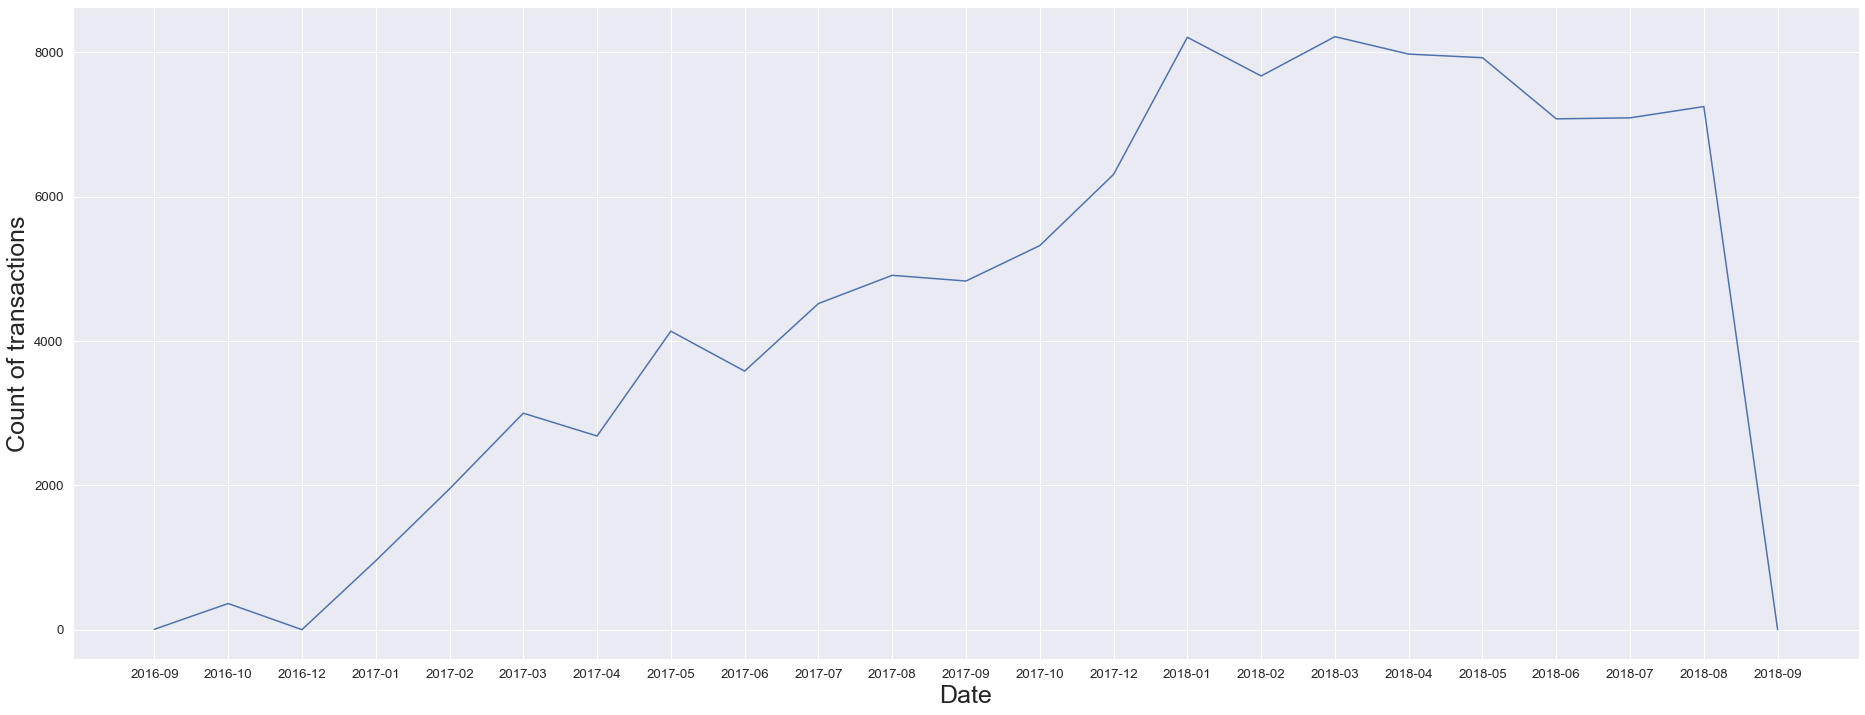

In [163]:
plt.rcParams["figure.figsize"] = (32,12)
sns.set(font_scale = 1.2)
sns.lineplot(full_df['date'].value_counts()[1:].index, full_df['date'].value_counts()[1:])#.set(xlabel = 'Date', ylabel= 'Count of transactions')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Count of transactions', fontsize=25)
# ticks_all = full_df['date'].value_counts()[1:].index
# ticks_sel = list(ticks_all[::2])
# plt.xticks(ticks_sel)

The number of transactions at the beginning of the dataset is minor, with just a few transactions per month. It is quickly increasing, with 2000 transactions in the 5th month. The peak is in November 2017 and it starts the best period for the website, with 7-8k transactions monthly.

The data looks like the business has opened in 2016-09, which would explain the small number of purchases. However, this would need to be confirmed by the data provider. 

The last transaction in the dataset happens at the beginning of 2018-09, which means 2 years data was provided.

#### Customers

In [238]:
print('Maximum number of orders done by unique customer: ', dt_orders['customer_id'].value_counts().max())

Maximum number of orders done by unique customer:  1


According to the data, no customer made more than one purchase ever. Because 2-years transactional data is available, the complete lack of returning or loyal customers is unlikely. This suggest that the customers anonymizing was on order level, not customer one.

This unfortunately greatly reduces the possible analyses that could be done with this data.   

#### Outliers

<ipython-input-4-607cc362a5f1>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


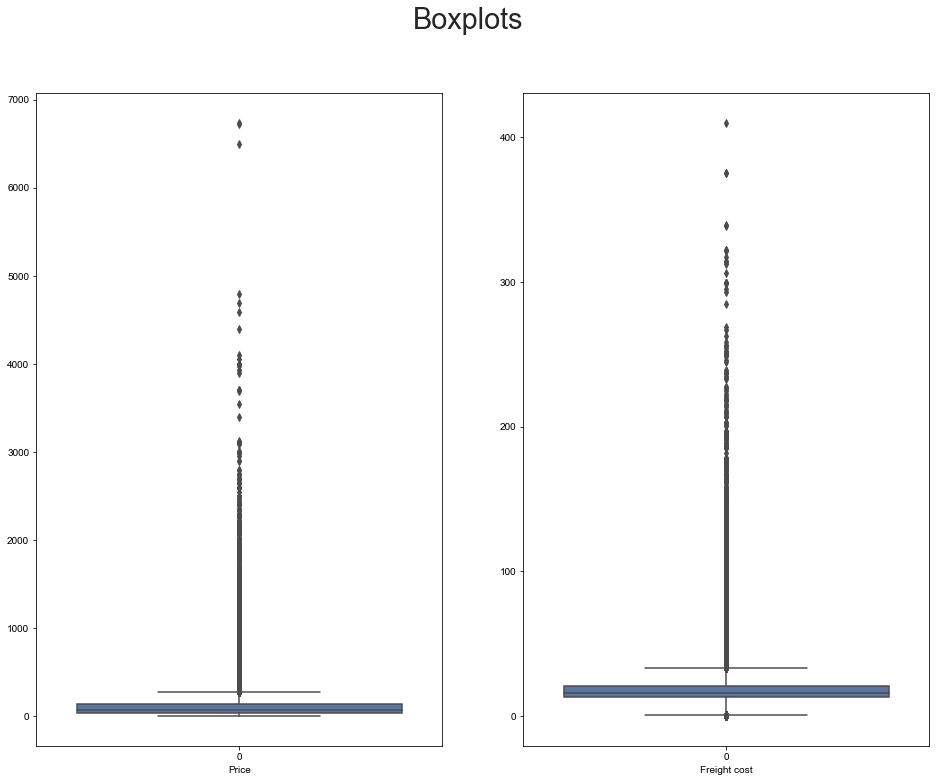

In [4]:
plt.rcParams["figure.figsize"] = (16,12)
fig, ax = plt.subplots(1,2)
sns.set(style="whitegrid", font_scale=2)
sns.boxplot(data=full_df['price'], ax=ax[0]).set(xlabel='Price')
sns.boxplot(data=full_df['freight_value'], ax=ax[1]).set(xlabel='Freight cost')
fig.suptitle('Boxplots')
fig.show()

In [73]:
full_df[full_df.price>5000]

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
3925,f5136e38d1a14a4dbd87dff67da82701,3fd6777bbce08a352fddd04e4a7cc8f6,delivered,2017-05-24 18:14:34,1bdf5e6731585cf01aa8169c7028d6ad,6499.0,227.66,art
25071,0812eb902a67711a1cb742b3cdaa65ae,c6e2731c5b391845f6800c97401a43a9,delivered,2017-02-12 20:37:36,489ae2aa008f021502940f251d4cce7f,6735.0,194.31,housewares
32077,fefacc66af859508bf1a7934eab1e97f,f48d464a0baaea338cb25f816991ab1f,delivered,2018-07-25 18:10:17,69c590f7ffc7bf8db97190b6cb6ed62e,6729.0,193.21,computers


In [74]:
full_df[full_df.freight_value>350]

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
57086,a77e1550db865202c56b19ddc6dc4d53,4eed76c1aafeceac4250e202ca9b1a5a,delivered,2018-04-16 14:57:21,ec31d2a17b299511e7c8627be9337b9b,979.00,409.68,baby
84927,076d1555fb53a89b0ef4d529e527a0f6,f08306b95370e8d5f0d97b71229284b6,delivered,2018-07-30 10:04:21,a3cd9517ebf5a50dca25acce54f3b171,2338.08,375.28,housewares
111396,3fde74c28a3d5d618c00f26d51baafa0,f2c743697f9b2ff2902df23a16582d80,delivered,2018-08-13 14:07:50,a3cd9517ebf5a50dca25acce54f3b171,2338.08,375.28,housewares


In [11]:
iqr = full_df.quantile(0.75) - full_df.quantile(0.25)
full_df_iqr = full_df[~((full_df < (full_df.quantile(0.25) - 1.5 * iqr)) |(full_df > (full_df.quantile(0.75) + 1.5 * iqr))).any(axis=1)]

<ipython-input-12-5a1fa1222804>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


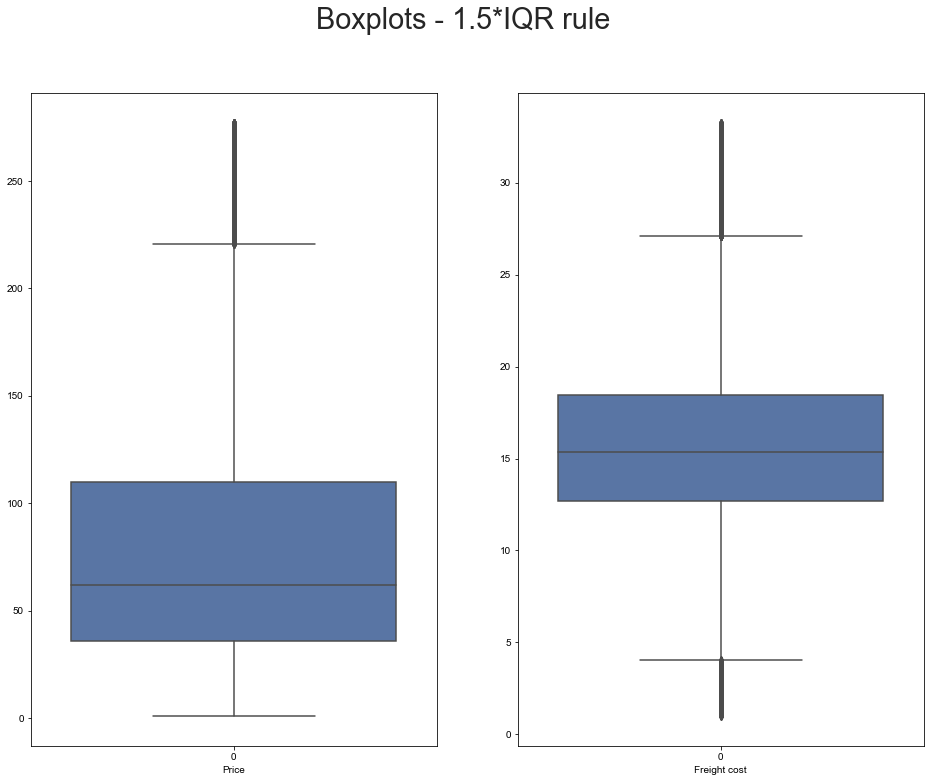

In [12]:
plt.rcParams["figure.figsize"] = (16,12)
fig, ax = plt.subplots(1,2)
sns.set(style="whitegrid", font_scale=2)
sns.boxplot(data=full_df_iqr['price'], ax=ax[0]).set(xlabel='Price')
sns.boxplot(data=full_df_iqr['freight_value'], ax=ax[1]).set(xlabel='Freight cost')
fig.suptitle('Boxplots - 1.5*IQR rule')
fig.show()

There are multiple observations that fall outside of the interquartile ranges for the Price and Freight value. However, there are no reasons to believe these are faulty records. In fact, there are only a few values cleary outstanding from the rest of the population. As their effect on clustering is unknown, both datasets with (full_df) and without (full_df_iqr) outliers will be tested.  

#### Distribution

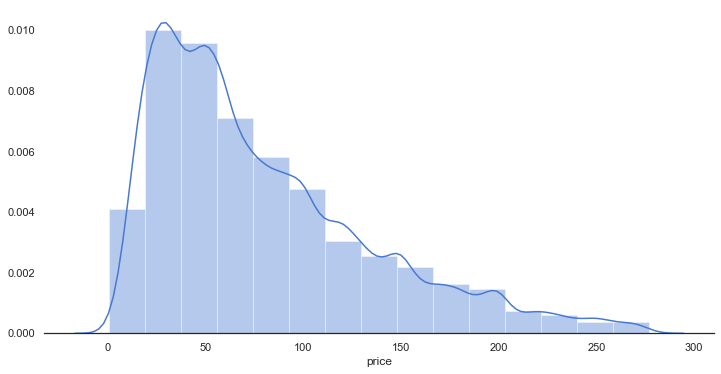

In [64]:
# import scipy.stats as stats
# sns.set(font_scale=1.5, palette='muted')
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
# sns.distplot(full_df_iqr['price'], bins=30, ax=ax1)
# # ax2 = plt.hist(full_df_iqr['freight_value'], bins=20)
# sns.distplot(full_df_iqr['freight_value'], bins=10, ax=ax2)

# for var, axx in zip ([full_df_iqr.price, full_df_iqr.freight_value], [ax1, ax2]):
    
#     mu = np.mean(var)
#     sigma = np.std(var)
#     pdf = stats.norm.pdf(sorted(var), mu, sigma)
#     if axx == ax1:sns.distplot(full_df_iqr['price'], bins=20, ax=axx)
#     else: axx = plt.plot(sorted(var), pdf, color='r', linewidth=2) #plt.hist(var, bins=30, density = True)
    
#     # plt.plot(sorted(var), pdf, color='r', linewidth=2)
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(full_df_iqr.price, bins=15)

Cena: rozkład prawoskośny, dostawa: upośledzony pseudonormalny

In [71]:
full_df_iqr.corr()

,price,freight_value
price,1.000000,0.306805
freight_value,0.306805,1.000000


### Feature engineering

any further analysis?
create freature with frequency

In [95]:
full_df.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
product_id                        object
price                            float64
freight_value                    float64
product_category_name_english     object
dtype: object

In [99]:
df = full_df.copy()
df['year'] = df['order_purchase_timestamp'].str[:4]
df['month'] = df['order_purchase_timestamp'].str[5:7]
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['date'] = df['order_purchase_timestamp'].dt.date

df

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english,year,month,date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,2017,10,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery,2018,07,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto,2018,08,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop,2017,11,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery,2018,02,2018-02-13
...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,baby,2018,02,2018-02-06
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,b80910977a37536adeddd63663f916ad,205.99,65.02,home_appliances_2,2017,08,2017-08-27
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,computers_accessories,2018,01,2018-01-08
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,d1c427060a0f73f6b889a5c7c61f2ac4,179.99,40.59,computers_accessories,2018,01,2018-01-08


In [70]:
# o co chodziło?
# ilość transackji na kilka miesięcy? średnia ich wartość?  

,order_id,customer_id,order_status,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,aa4383b373c6aca5d8797843e5594415,159.90,19.22,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,stationery
...,...,...,...,...,...,...,...,...
112639,cfa78b997e329a5295b4ee6972c02979,a2f7428f0cafbc8e59f20e1444b67315,delivered,2017-12-20 09:52:41,3d2c44374ee42b3003a470f3e937a2ea,55.90,15.14,musical_instruments
112643,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,ea73128566d1b082e5101ce46f8107c7,139.90,16.09,furniture_decor
112644,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,ac35486adb7b02598c182c2ff2e05254,72.00,13.08,health_beauty
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,f1d4ce8c6dd66c47bbaa8c6781c2a923,174.90,20.10,baby


przy robieniu kmeans warto sprawdzić czy po wyrzuceniu outlierów lub po standaryzacji (by otrzymać bliej rozkładu normalnego) nie ma lepszych wynków

The solution might indeed be more stable with Gaussian distributed variables because the variance is sensitive to outliers. So outliers could certainly be driving the solutions you arrive at.
My experience is that K-means, as with many traditional methods, is fairly robust to violations of normality when the magnitude of the noise is not large.